<a href="https://colab.research.google.com/github/zachary013/lab1-deep-learning/blob/main/lab1_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import kagglehub
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [19]:
# NYSE dataset for regression
nyse_path = kagglehub.dataset_download("dgawlik/nyse")
print("NYSE dataset path:", nyse_path)

# Machine Predictive Maintenance dataset for classification
maintenance_path = kagglehub.dataset_download("shivamb/machine-predictive-maintenance-classification")
print("Maintenance dataset path:", maintenance_path)

NYSE dataset path: /root/.cache/kagglehub/datasets/dgawlik/nyse/versions/3
Maintenance dataset path: /root/.cache/kagglehub/datasets/shivamb/machine-predictive-maintenance-classification/versions/1


                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       70.836986      70.857109      70.118414      71.543476   
std        83.695876      83.689686      82.877294      84.465504   
min         0.850000       0.860000       0.830000       0.880000   
25%        33.840000      33.849998      33.480000      34.189999   
50%      

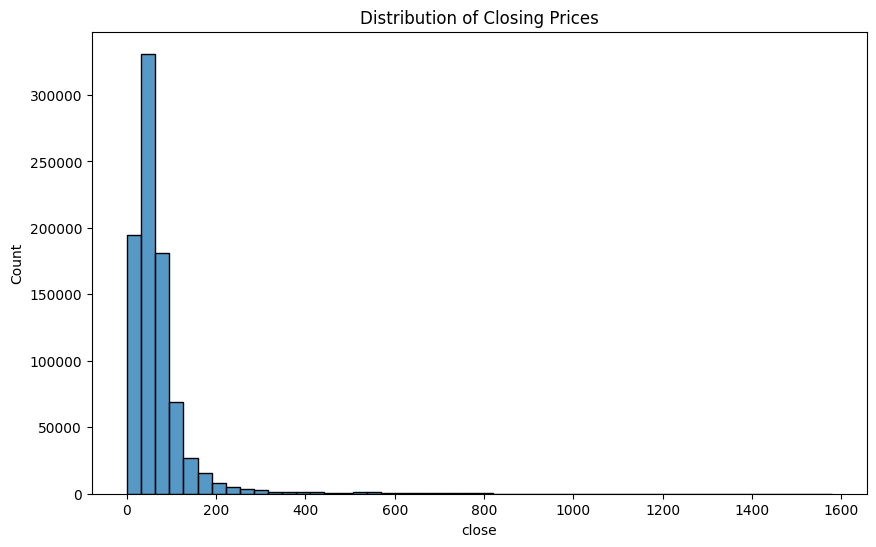

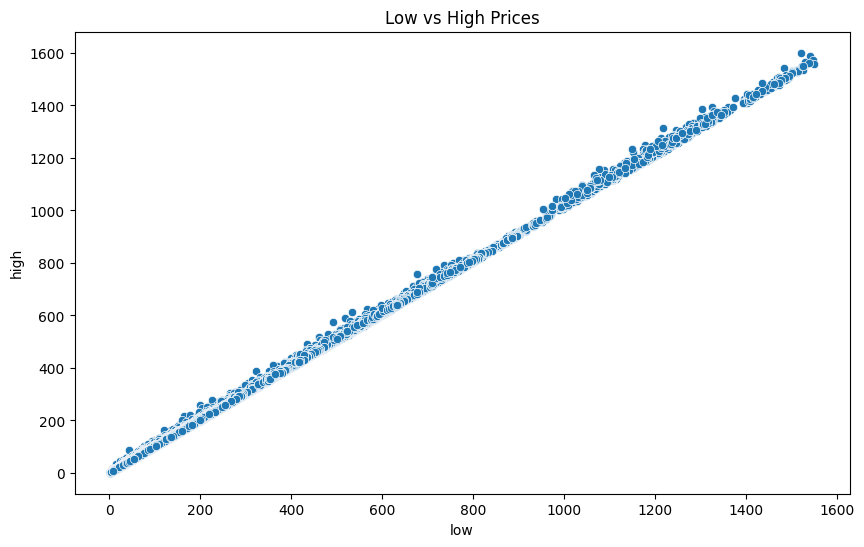

In [20]:
# Load NYSE data (update path based on Cell 3 output)
data = pd.read_csv(f'{nyse_path}/prices.csv')  # Adjust filename if needed

# Basic exploration
print(data.head())
print(data.describe())
print(data.isnull().sum())

# Visualizations
plt.figure(figsize=(10, 6))
sns.histplot(data['close'], bins=50)
plt.title('Distribution of Closing Prices')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='low', y='high', data=data)
plt.title('Low vs High Prices')
plt.show()

In [ ]:
# Prepare data
X = data[['open', 'high', 'low']].values
y = data['close'].values

# Split and standardize
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Define DNN
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = DNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:  # Print every 10 epochs
        print(f'Epoch {epoch}, Loss: {loss.item()}')

Epoch 0, Loss: 12057.4716796875
Epoch 10, Loss: 10493.6884765625
Epoch 20, Loss: 5785.9326171875
Epoch 30, Loss: 663.4561157226562
Epoch 40, Loss: 878.5108032226562
Epoch 50, Loss: 286.0442810058594
Epoch 60, Loss: 79.90647888183594
Epoch 70, Loss: 62.01355743408203
Epoch 80, Loss: 33.690223693847656
Epoch 90, Loss: 18.731935501098633


In [17]:
class PyTorchRegressor:
    def __init__(self, lr=0.01, optimizer='adam'):
        self.model = DNN()
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr) if optimizer == 'adam' else torch.optim.SGD(self.model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def fit(self, X, y, epochs=50):
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y)
        for _ in range(epochs):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y.view(-1, 1))
            loss.backward()
            self.optimizer.step()

    def predict(self, X):
        X = torch.FloatTensor(X)
        self.model.eval()
        with torch.no_grad():
            return self.model(X).numpy()

# Manual GridSearch
param_grid = {'lr': [0.001, 0.01, 0.1], 'optimizer': ['adam', 'sgd']}
best_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    model = PyTorchRegressor(lr=params['lr'], optimizer=params['optimizer'])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    loss = nn.MSELoss()(torch.FloatTensor(pred), y_test.view(-1, 1)).item()
    if loss < best_loss:
        best_loss = loss
        best_params = params

print(f'Best params: {best_params}, Best loss: {best_loss}')

Best params: {'lr': 0.1, 'optimizer': 'adam'}, Best loss: 17.600706100463867


In [ ]:
model = DNN()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
train_losses, test_losses, train_maes, test_maes = [], [], [], []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    train_mae = torch.mean(torch.abs(outputs - y_train.view(-1, 1))).item()
    train_maes.append(train_mae)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test.view(-1, 1))
        test_losses.append(test_loss.item())
        test_mae = torch.mean(torch.abs(test_outputs - y_test.view(-1, 1))).item()
        test_maes.append(test_mae)

# Plot
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_maes, label='Train MAE')
plt.plot(test_maes, label='Test MAE')
plt.title('MAE vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

print("Interpretation: If train loss drops but test loss plateaus, it might mean overfitting.")

In [ ]:
class DNNRegularized(nn.Module):
    def __init__(self):
        super(DNNRegularized, self).__init__()
        self.fc1 = nn.Linear(3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

model = DNNRegularized()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=0.01)
